# 3. Gradient Descent for Regression

### Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
from collections import deque
import matplotlib.pyplot as plt

### Global

In [2]:
np.random.seed = 12345
datasets_path = "../Datasets/"

### Variables

In [3]:
# Storing data in dataframes, and dropping a random column with unknown values in it, plus renaming the columns
df_train = pd.read_csv(datasets_path + 
                       "Dataset_2_train.csv", 
                       header = None).drop(labels=2, axis=1).rename(index=str, columns={0: "x", 1: "y"})
df_test = pd.read_csv(datasets_path + 
                      "Dataset_2_test.csv", 
                      header = None).drop(labels=2, axis=1).rename(index=str, columns={0: "x", 1: "y"})
df_val = pd.read_csv(datasets_path + 
                     "Dataset_2_valid.csv", 
                     header = None).drop(labels=2, axis=1).rename(index=str, columns={0: "x", 1: "y"})

## Part 1

In [26]:
patience = 100  # To measure learning stature

In [27]:
def loss(xs, ys, w):
    ys = np.asarray(ys)
    return np.asarray(xs.dot(w) - ys).dot(xs)/len(xs)

def mse(xs, ys, w):
    ys = np.asarray(ys)
    return (np.asarray(xs.dot(w) - ys) ** 2).mean()

def plot_fcts(xs, ys, w):
    x_lin = np.linspace(min(xs[:,-1]), max(xs[:,-1]), 200)
    x_lin = np.hstack((np.ones_like(x_lin), x_lin)).reshape(2, len(x_lin)).T

    plt.plot(x_lin[:,-1], x_lin.dot(w), 'ro',
             xs[:,-1], ys, 'bo')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [57]:
def train(df_train, df_val, w, learning_rate = 1e-6, print_ = False):
    # train and valication data
    xs, ys = df_train.x.values, df_train.y.values
    xs = np.hstack((np.ones_like(xs), xs)).reshape(2, len(xs)).T  # for matrix multiplication
    x_val, y_val = df_val.x.values, df_val.y.values
    x_val = np.hstack((np.ones_like(x_val), x_val)).reshape(2, len(x_val)).T  # for matrix multiplication

    # rolling window over MSE to stop when stature
    all_mse_val, all_mse_tr = [], []
    epoch = 0
    
    # Training loop, stoping based on rolling_mse
    while True:
        # choosing x randomly, to introduce randomess in the model
        position = np.random.randint(0,len(xs))
        x = xs[position]
        y = ys[position]

        w -= learning_rate * loss(x, y, w)
        current_mse_val, current_mse_tr = mse(x_val, y_val, w), mse(xs, ys, w)

        # add MSEs and loss to lists
        all_mse_val.append(current_mse_val)
        all_mse_tr.append(current_mse_tr)        

        # evaluate model every N steps and stop if stature
        if epoch % patience == 0:
            if print_:
                print("Epoch", epoch)
                plot_fcts(xs,ys,w)
            if epoch >= patience:
#                 print("Epoch #%s: MSE = %s" % (epoch, np.mean(all_mse_val[int(-patience/2):])))
#                 print(np.mean(all_mse_val[-patience:int(-patience/2)]) - np.mean(all_mse_val[int(-patience/2):]))
                if np.mean(all_mse_val[-patience:int(-patience/2)]) < np.mean(all_mse_val[int(-patience/2):]):
                    # Not learning anymore, returning all mse
                    print("Epoch #%s: MSE = %s" % (epoch, np.mean(all_mse_val[int(-patience/2):])))
                    return all_mse_tr, all_mse_val, w, epoch
        
        epoch += 1

In [58]:
w_ = np.random.rand(2)*10
print(w_)
all_mse_train_, all_mse_val_, weights_, epoch_ = train(df_train, df_val, w_, 1e-6)

[ 2.60865947  2.3338723 ]
Epoch #3864500: MSE = 0.173552163312


 
3.98 x + 3.721


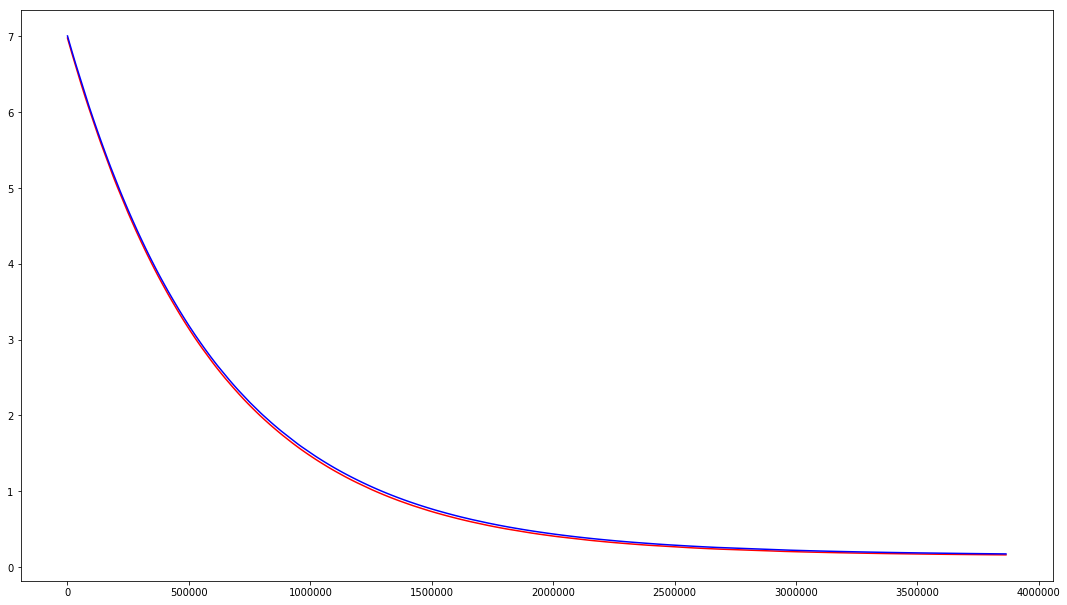

In [59]:
print(np.poly1d(weights_))
x_lin = np.linspace(0, epoch_, epoch_+1)
plt.plot(x_lin, all_mse_train_, 'r', x_lin, all_mse_val_, 'b')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Part 2

### Different learning rate (2.a)

In [60]:
step_size = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]  # not doing 1e-6 again

In [61]:
mse_val_all, coeffs, epoch, ws_all = [], [], [], []

for alpha in step_size:
    weights = np.random.rand(2)*10
    mse_tr, mse_val, w_s, e = train(df_train, df_train, weights, alpha)
    print("For alpha %s (after %s epoch): MSE = %s" % (alpha, e, mse_val[-1]))
    mse_val_all.append(mse_val)
    coeffs.append(w_s)
    
print("For alpha %s (after %s epoch): MSE = %s" % ('1e-06', epoch_, all_mse_val_[-1]))
mse_val_all.append(all_mse_val_)
coeffs.append(weights_)


Epoch #400: MSE = 0.115108693384
For alpha 0.1 (after 400 epoch): MSE = 0.124688921215
Epoch #5100: MSE = 0.106917971985
For alpha 0.01 (after 5100 epoch): MSE = 0.106715953517
Epoch #25200: MSE = 0.104546066693
For alpha 0.001 (after 25200 epoch): MSE = 0.104527986805
Epoch #394600: MSE = 0.104174377386
For alpha 0.0001 (after 394600 epoch): MSE = 0.1041746476
Epoch #503900: MSE = 0.175635797945
For alpha 1e-05 (after 503900 epoch): MSE = 0.175632847689
For alpha 1e-06 (after 3864500 epoch): MSE = 0.173551892354


### Optimal solution (2.b)

In [62]:
def get_test_mse(best_model_pos):
    xs, ys = df_test.x.values, df_test.y.values
    xs = np.hstack((np.ones_like(xs), xs)).reshape(2, len(xs)).T  # for matrix multiplication
    w = coeffs[best_model_pos]
    return mse(xs, ys, w)

In [63]:
best_model = mse_val_all.index(min(mse_val_all))
test_mse = get_test_mse(best_model)
print("Best MSE is %s with alpha = %s" % (test_mse, step_size[best_model]))

Best MSE is 0.104292611125 with alpha = 0.1


## Part 3

Epoch 0


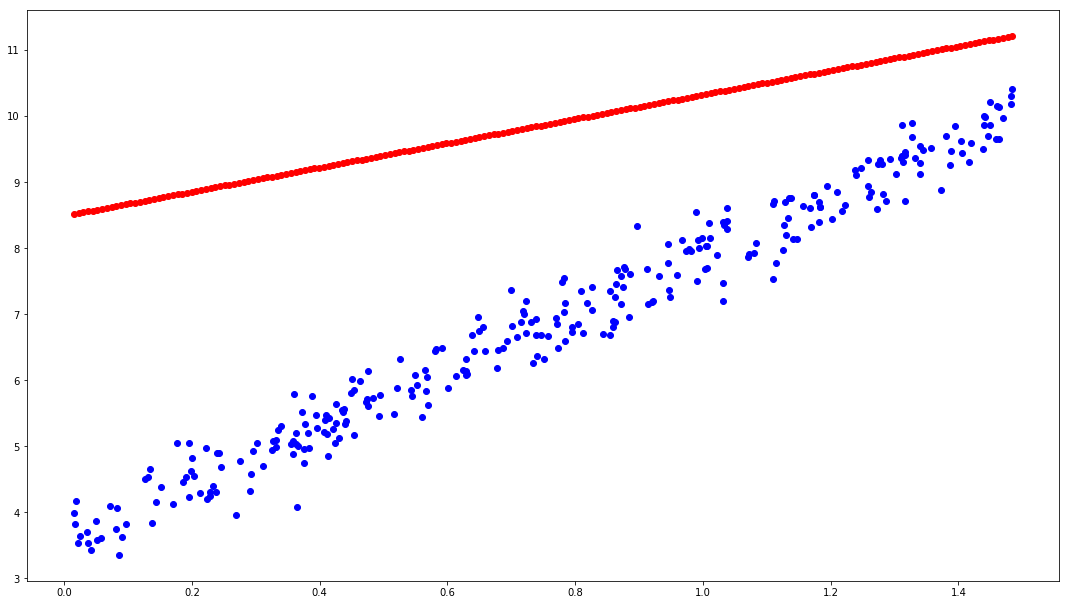

Epoch 100


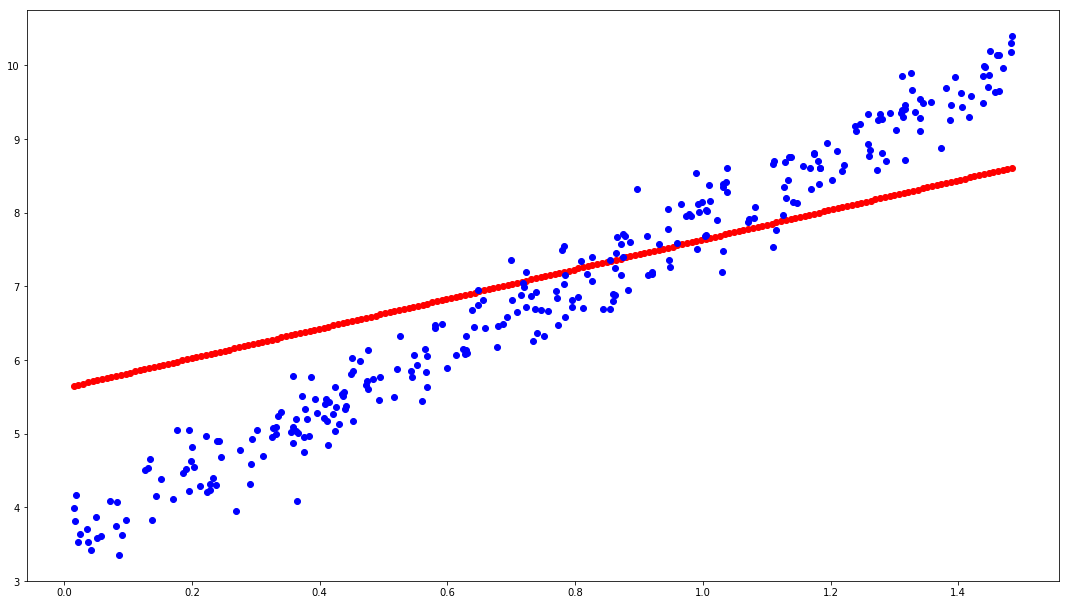

Epoch 200


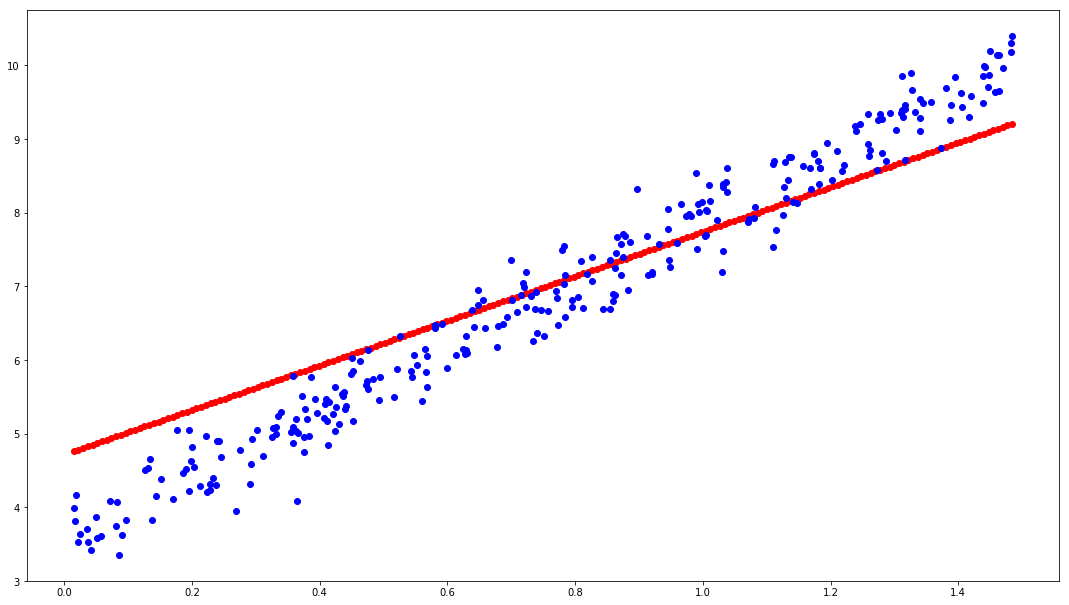

Epoch 300


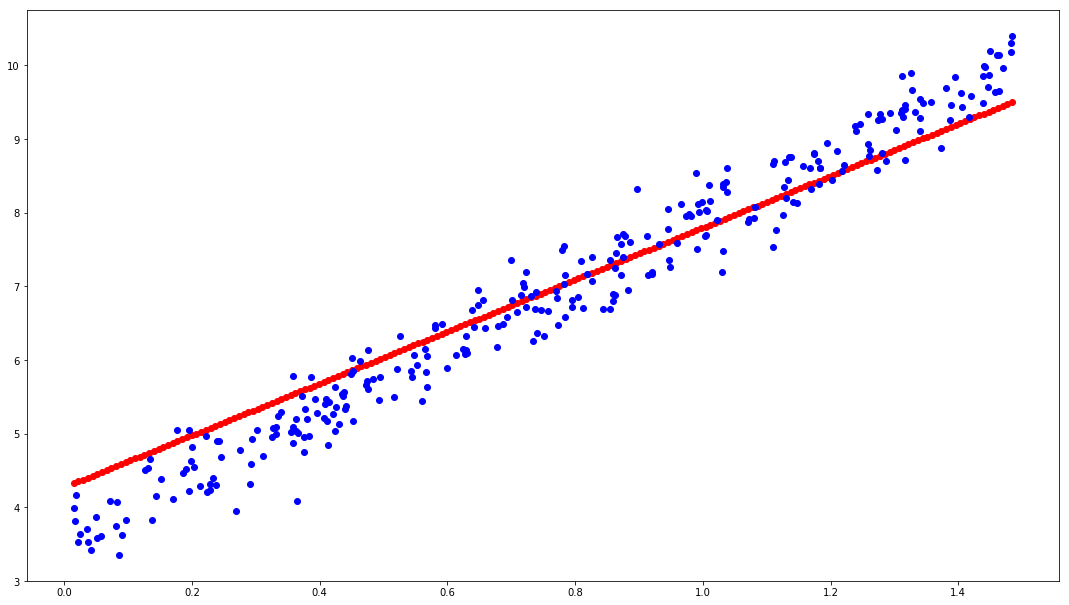

Epoch 400


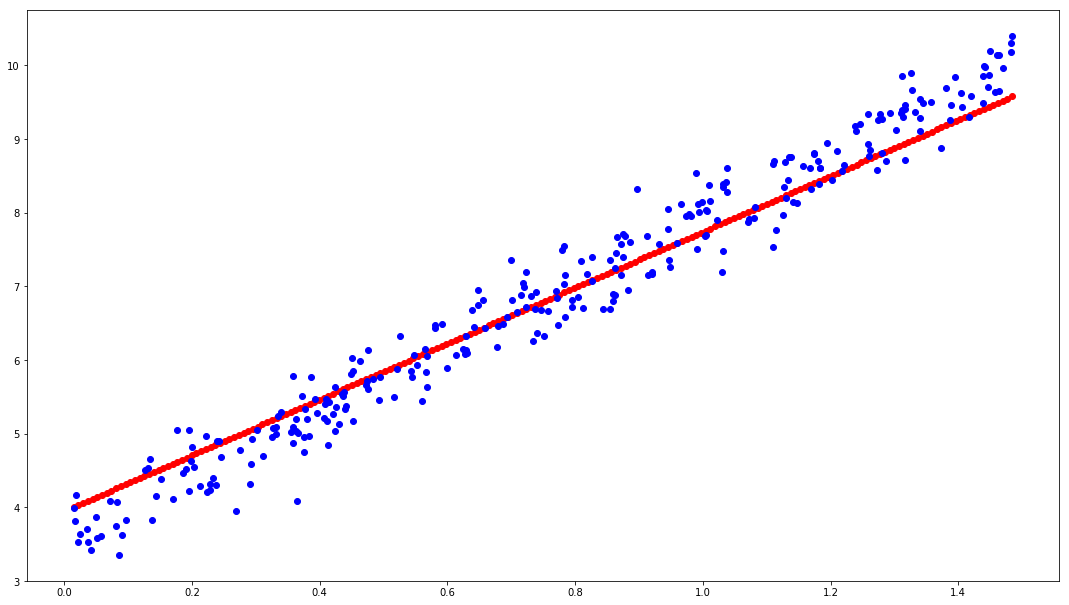

Epoch 500


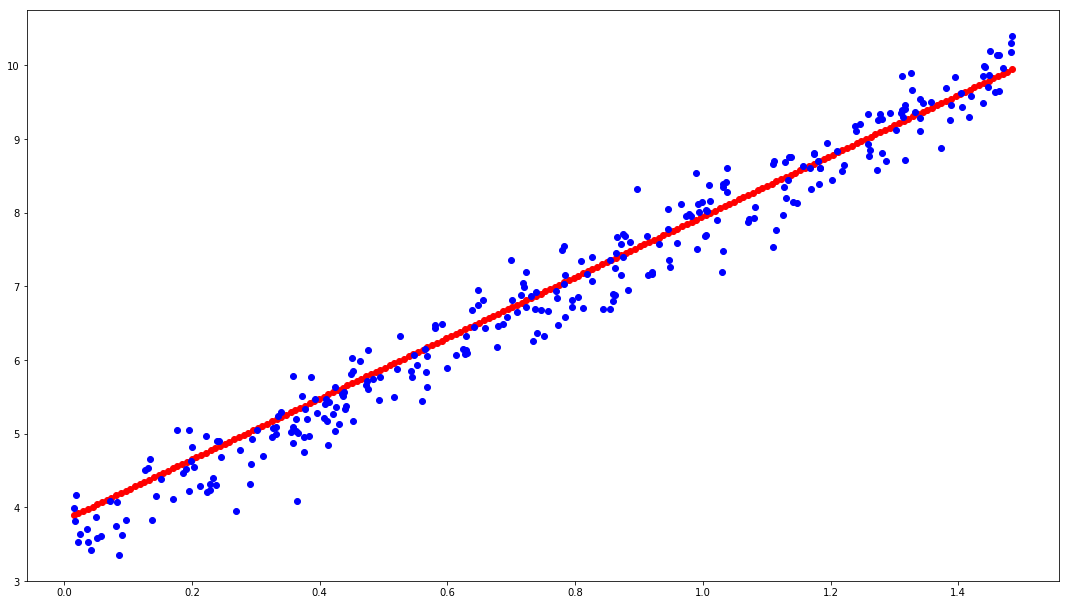

Epoch 600


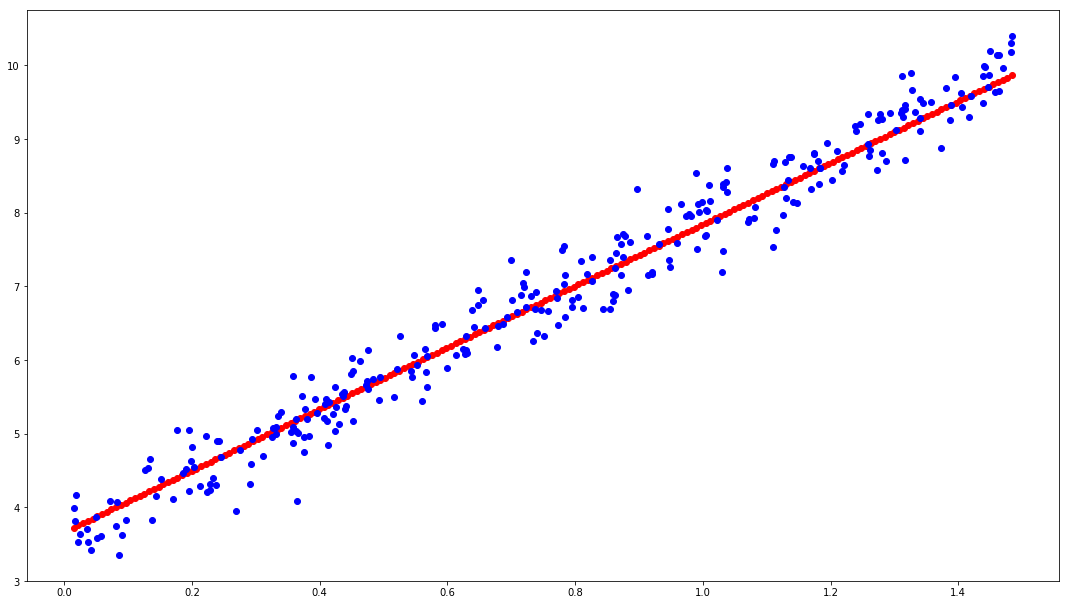

Epoch 700


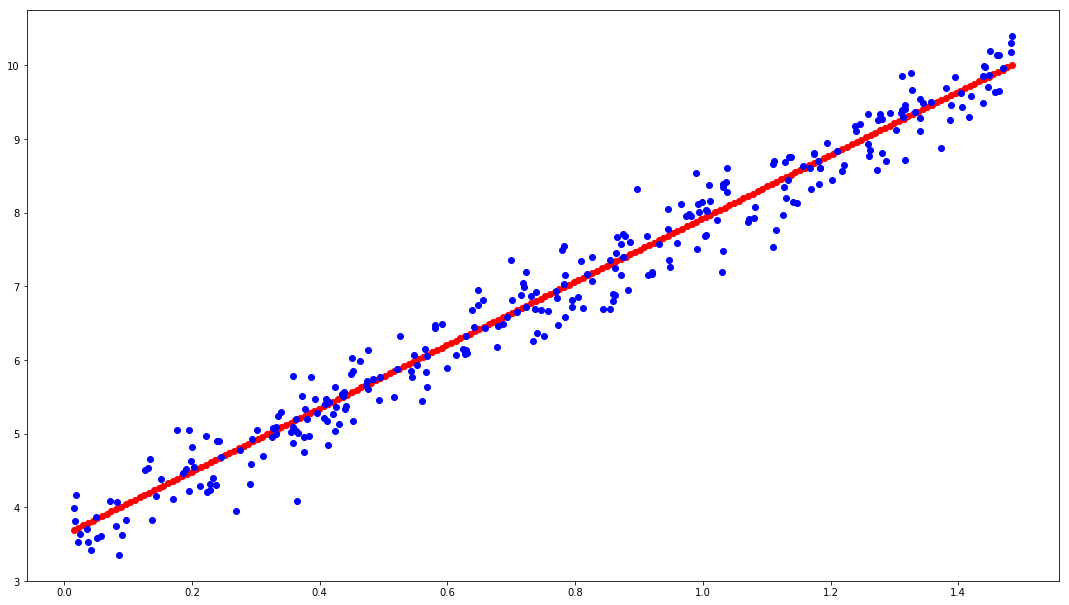

Epoch 800


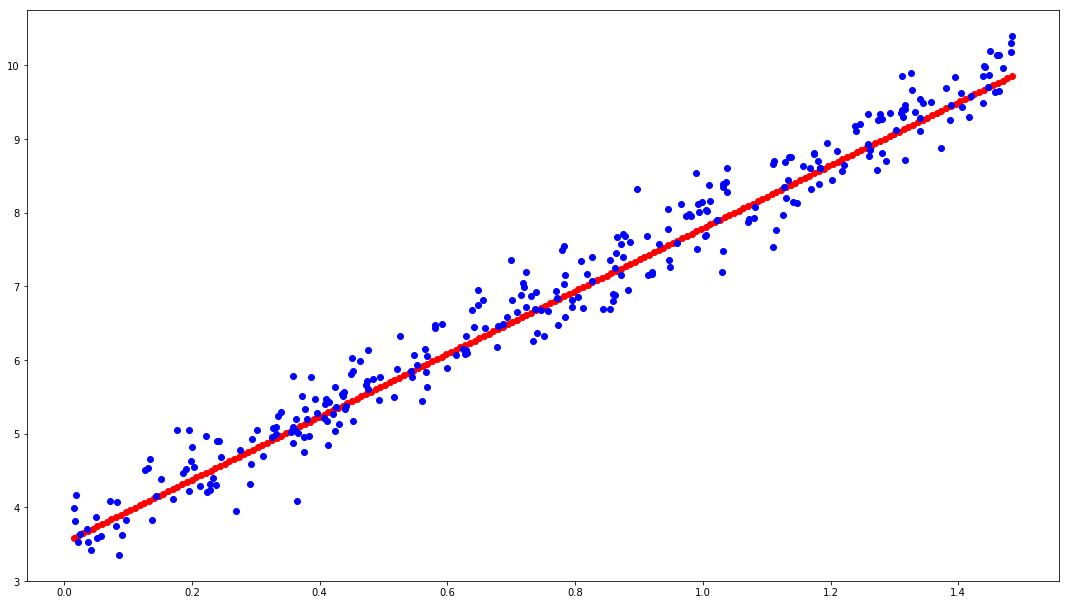

Epoch #800: MSE = 0.078397541473


In [64]:
done = train(df_train, df_val, np.random.rand(2)*10, 1e-1, True)